# Quantum Information Final
Gregory Croisdale, Cade Brown, Rebecca Ryan
University of Tennessee, Knoxville
PHYS 494

For a dynamic version of this page, download and run the repository at the following address: <br>
https://github.com/gcrois/QFastInteger

See the readme for other sources and requirements.

In [1]:
%run implementations/lucas-lehmer.ipynb
%run implementations/shors.ipynb
%run implementations/integer-mult.ipynb
%run implementations/rsa.ipynb

import time
import random
import numpy as np
import matplotlib.pyplot as plt

Success!
Integer Multiplication Success!
RSA Successful!


# RSA (and Shor's Algorithm)

RSA, a secure encryption algorithm, is used for sending private data across unsecure public connections, utilizing public and private keys. Essentially, anyone can have your public key, and they can use that to encrypt a message to send you. However, only the person with the private key can decrypt the message and view the secret data.

The way this can happen and be secure to outside attackers is due to the math behind it. By sing a few formulas, turning any text/images into numbers, you can safely send the encrypted data (which looks nothing like the original message) across lines where other people may view it, but only the owner of the private key will be able to view the original intended message.


## The Maths

The basis for any RSA keypair are two prime numbers $p$ and $q$. Then, a few other numbers are defined:

$N=pq$

$\mathrm{tot}=\mathrm{lcm}(p-1,q-1)=(q-1)(p-1)/\mathrm{gcd}(p-1, q-1)$

$e = ($random number coprime to 'tot'$)$

$d = e^{-1} (\mod \mathrm{tot})$


Now, we have our key pairs:

public: $(N, e)$

private: $(N, d)$


We can give the public key out to anyone on in the world, but only we should be able to have private key (we keep it locked up)



Now, with the following rules, we can take an original message $m$ amd encrypt it:


$m_{enc} = m ^ e (\mod N)$


And, to get the original message:

$m_{dec} = m_{enc} ^ d (\mod N)$

And, assuming you have the correct private key, $m_{dec} = m$


Notice how the encryption step did not require $d$, so anyone can encrypt something to send to you, but the decryption step requires $e$, which only the person who created the key should have. 


This works because any number's power series mod $N$ is cyclic every $\phi(N)$ (i.e. the totient function), and the totient function is defined as: $\phi(N)=(p-1) * (q-1)$, since $N$ only has 2 prime factors. And therefore, $a^i = a^{i \mod \phi(N)}$.

Looking back, we see that:

$m_{dec} = m_{enc} ^ d (\mod N) = (m ^ e) ^ d (\mod N) = m ^ {e * d} (\mod N) = m ^ {e * d \mod \phi(N)} (\mod N)$

And, further, since $e$ and $d$ were chosen to be multiplicative inverses modulo $\phi(N)$ (i.e. that $ed = 1 \mod \phi(N)$), we have that:

$m_{dec} = m ^ {1 \mod \phi(N)} (\mod N) = m ^ 1 (\mod N) = m $

And voila! The decrypted result will always be the same as the original message (modulo N)







In [2]:
# how large should the key be?
nbits = 8
base = 2 ** nbits

# generate a public and private key pair
pub, pri = gen_keypair(nbits)

# priunt them out
print (pub, pri)

# now, try sending a message

msg_txt = "Meet me at the bridge!"

print ("sending message:", msg_txt)

msg = [ord(c) for c in msg_txt]

msg_enc = rsa_enc(pub, msg)
print ("encrypted:", msg_enc)

msg_dec = rsa_dec(pri, msg_enc)
print ("decrypted:", msg_dec)


# convert back to text
msg_dec_txt = "".join([chr(c) for c in msg_dec])

print ("received message:", msg_dec_txt)

assert (msg_txt == msg_dec_txt)
print ("Success!")

(20701, 835) (20701, 823)
sending message: Meet me at the bridge!
encrypted: [17107, 1022, 1022, 18882, 16645, 5998, 1022, 16645, 9372, 18882, 16645, 18882, 10699, 1022, 16645, 15949, 12257, 19013, 8026, 15085, 1022, 20330]
decrypted: [77, 101, 101, 116, 32, 109, 101, 32, 97, 116, 32, 116, 104, 101, 32, 98, 114, 105, 100, 103, 101, 33]
received message: Meet me at the bridge!
Success!


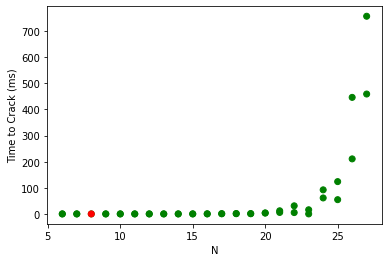

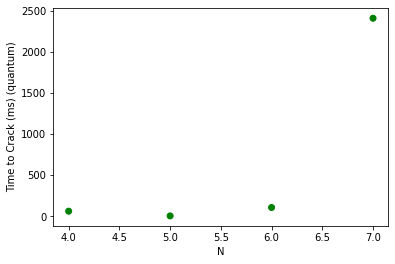

In [4]:
# now, let's try breaking it!

# list of tries
bits = []
times = []
is_broken = []

# try breaking various ranges
for b in range(6, 28):
    for j in range(2):
        pub, pri = gen_keypair(b)
        bits += [b]
        st = time.time()
        pri_broken = crack_rsa_1(pub)
        times += [(time.time() - st) * 1000.0]
        is_broken += [pri_broken == pri]


    
plt.scatter(bits, times, c=['green' if b else 'red' for b in is_broken])
plt.xlabel("N")
plt.ylabel("Time to Crack (ms)")
plt.show()

# list of tries
bits = []
times = []
is_broken = []

# NOTE: Sometimes there will be an overflow error from qiskit in this section
# or it may take a long time. Run this cell a if that happens.
# try breaking various ranges
for b in range(4, 8):
    for j in range(1):
        pub, pri = gen_keypair(b)
        bits += [b]
        st = time.time()
        pri_broken = crack_rsa_quantum(pub) # we are using shor's for this portion
        times += [(time.time() - st) * 1000.0]
        is_broken += [pri_broken == pri]


# NOTE: this is smaller sample size because the quantum simulator is slow
plt.scatter(bits, times, c=['green' if b else 'red' for b in is_broken])
plt.xlabel("N")
plt.ylabel("Time to Crack (ms) (quantum)")
plt.show()

# Lucas Lehmer Test


The Lucas Lehmer test is a primality test for a specific form of numbers (numbers which are 1 less than a power of 2). It runs faster than many other primality tests for these numbers, but does not give the specific factors as a result (so it is not a factoring algorithm)


# Algorithm

Definitions:

$ M_p = 2^{p} - 1, p \in \mathbb{P}, p > 2 $

$ L_{i+1} = L_{i} ^ 2 - 2, L_0 = 4$


$ M_p $ is prime if $ p $ is prime, and $ L_{p-2} = 0$ (mod $M_p$)


Otherwise, $ M_p $ is composite. Additionally, each $ L_i $ can be reduced modulo $M_p$ to keep intermediate results a reasonable size.

This algorithm is a good example of a fast primality test for classical computers, and has been used to find the world records for largest primes for the last 20 years.




Mersenne Exponents: [3, 5, 7, 13, 17, 19, 31, 61, 89, 107, 127, 521, 607, 1279, 2203, 2281]


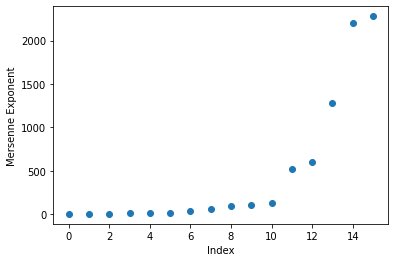

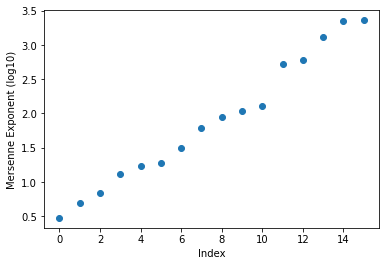

In [5]:
# example exponents which mersenne numbers are prime
M_exps = list(filter(LLtest, range(3, 3000, 2)))
print ("Mersenne Exponents:", M_exps)


# plot the exponents on a chart
plt.scatter(range(len(M_exps)), M_exps)
plt.xlabel('Index')
plt.ylabel('Mersenne Exponent')

plt.show()

# now, plot on a log scale

plt.scatter(range(len(M_exps)), np.log10(M_exps))
plt.xlabel('Index')
plt.ylabel('Mersenne Exponent (log10)')

plt.show()

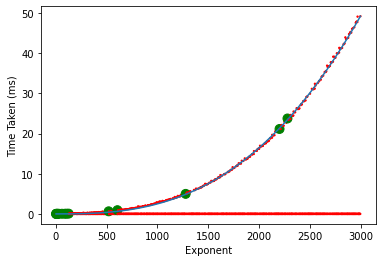

In [6]:
# plotting runtimes for the test
# NOTE: There may be some shortcuts (like if the exponent is not prime),
#   so some runtimes will be close to 0

# create arrays for the results
exps = range(3, 3000, 2)
is_prime = []
times = []

for p in exps:
    st = time.time()
    is_prime += [LLtest(p)]
    # add time in ms
    times += [(time.time() - st) * 1000.0]
    
    
# now, plot times
# array of exponents
aE = np.array(exps)
# approximate fit: O(n^2 * log(n))
# in reaity, Python's big integer library uses less-than-optimal multiplication,
#   so the measured times are faster
# realy the complexity is O(n * log(n) * Mult(n)), where Mult(n) is the multiplication complexity
# Since Python uses karatsuba, Mult(n) = n^1.58
# So, the real O is O(n^2.58 * log(n))

# simple interpolation coefficient
alpha = times[-1] / (aE[-1] ** 2.58 * np.log(aE[-1]))
plt.plot(exps, alpha * aE ** 2.58 * np.log(aE))


# scatter plot the actual times
plt.scatter(exps, times, s=[80 if iP else 1.8 for iP in is_prime], color=['green' if iP else 'red' for iP in is_prime])
plt.xlabel('Exponent')
plt.ylabel('Time Taken (ms)')

plt.show()

# Integer Multiplication

Integer multiplication is the problem of finding the product of 2 whole numbers (i.e. finding $A*B$, given $A$ and $B$). The classic 'gradeschool' algorithm is $O(N^2)$ where $N$ is the size of the inputs (in bits).

However, using the Fast-Fourier-Transform (FFT), that can be sped up to approximately $O(N\log(N)\log(N)^2)$.

Multiplication of 2 integers is essentially convolution of their digits; for each digit in $A$, we have a copy of $B$ added to the output sequence, which is multiplied by that digit and shifted the number of spaces that the digit was shifted in $A$.

For example, taking $23 * 45$ ($A=23, B=45$) can be done simply like:

```
  23
x 45
----
  45 (*3)
 45  (*2)
----
 135
 90
----
1035

```

Since, effectively, you can choose $A$ or $B$ to be the amplitudes of the shifted copies of the other one, we can do effectively the same thing through convolution, using FFTs:

$A*B=\textrm{IFFT}(\textrm{FFT}(A) .* \textrm{FFT}(B))$ (where $.*$ is pointwise multiplication)

The difference in complexity comes from the fact that FFT and IFFT have complexity of $O(N\log(N))$ and pointwise multiplication of small machine words is $O(N)$, and thus the total running time is (approximately) $O(N\log(N))$, not accounting for carry. In reality, it becomes $O(N\log(N)\log\log(N))$ when using error correction, etc.


Unfortunately, Python doesn't allow direct memory access to the bytes of an integer, so extra steps must be taken to convert it into a string of words for manipulation. However, we account for this in our timing and only account for the FFT/conversion.





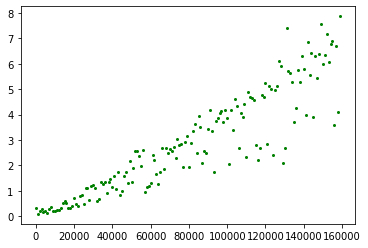

In [7]:
# timing our integer multiplication

# stats dictionary
st = {}

# store statistics
sizes = []
times = []


# do a random sampling of different bit sized inputs
for bits in range(2, 160000, 1000):
    # generate 2 random numbers
    a = random.getrandbits(bits)
    b = random.getrandbits(bits)

    sizes += [(a.bit_length() + b.bit_length()) / 2]

    res = intMM(a, b, st)
    #st['time'] = time.time()
    #res = a * b
    #st['time'] = (time.time() - st['time']) * 1000.0
    
    times += [st['time']]
    
    # ensure correctness
    #assert a * b == res


sizes = np.array(sizes)
times = np.array(times)

# scatter plot the size and times
plt.scatter(sizes, times, c='green', s=4)
plt.show()
